# General notes
- Some lines are commented out or contain changeable parameters in functions. Search 'CHANGE' to find them. Transformation numbers can be changed if needed.<br>
- Make sure all of the images of the pieces are of a square shape (widht=height).

# Download and import resources
Make sure that you have installed all required modules.  <br>
 - OpenCV: https://github.com/opencv/opencv <br>
 - imgaug: https://github.com/aleju/imgaug <br>
 - Shapely: https://github.com/Toblerity/Shapely <br>
 - tqdm (not required): https://github.com/tqdm/tqdm <br>
 
A few additional remarks: <br>
 - Shapely may not work properly when installed from a clone. In this case, install from a .whl (wheel) file instead: https://www.lfd.uci.edu/~gohlke/pythonlibs/#shapely. Download the appropriate .whl file (for example: 'Shapely‑1.7.0‑cp37‑cp37m‑win_amd64.whl' for 64 windows and Python 3.7) and install from directory.<br>
 - tqdm is used to display progress bars

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import os
import imgaug as ia
from imgaug import augmenters as iaa
from shapely.geometry import Polygon
from shapely.geometry import box
import time
import io
import glob
from tqdm import tqdm

### Download backgrounds
Different backgrounds are needed for the generation of random compositions. At least a few thousand different background images are recommended. They can be found online or collected by yourself. To save time, I recommend downloading [this](https://www.robots.ox.ac.uk/~vgg/data/dtd/) set, which is also used in this notebook. To download it, run the cells below.

In [2]:
import requests
import tarfile

# Download backgrounds
BACKGROUNDS_FILENAME='desctex.tar.gz'
BACKGROUNDS_URL='https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz'

response = requests.get(BACKGROUNDS_URL)
with open(BACKGROUNDS_FILENAME, 'wb') as file:
    file.write(response.content)
    
# Unzip the downloaded file
tar = tarfile.open(BACKGROUNDS_FILENAME, "r:gz")
tar.extractall()
tar.close()

Among the downloaded backgrounds, there is a non-image file that needs to be deleted.

In [3]:
folder_of_file=os.path.join('dtd', 'images','waffled')
name_of_file='.directory'
if os.path.exists(os.path.join(folder_of_file, name_of_file)):
    os.remove(os.path.join(folder_of_file, name_of_file))
    print('Non-image file found and deleted.')
else:
    print('Non-image file already deteleted.')

Non-image file found and deleted.


# Define some variables
All of the images have the same width and height sizes. When talking about image dimension, a definition dimension=width=height is used. Final image dimension is recommended to be 720px. For example, setting this size to 1080px, will ~double the generating and computing time. 

In [4]:
orig_dim=1080 # Dimension of the pieces images

fin_dim=1250 # Dimension of the image we will be working on before resizing it to the 'end_dim'

end_dim=720 # Dimension of the generated images (recommeded 720)

board_size=395 # In milimeters
board_inner_size=344 # In milimeters
images_pieces_size=410 # In milimeters

# Calculate the 
board_in_orig=orig_dim*board_inner_size/images_pieces_size # Dimension of the inner part of the board in images_pieces in pixels

FIX=20
board_dim=int(board_in_orig*board_size/board_inner_size)-FIX

# Define some paths
pathbgr=os.path.join('dtd', 'images') # Background folder
pathpieces='images_pieces' # Folder with images of pieces

# Define image overlaying functions

## Load a random background function

In [5]:
# Load a random background from the given directory and resize it to (final_imageW, final_imageH) function
def load_random_background(fd=fin_dim):
    n=0
    random.seed();
    for root, dirs, files in os.walk(pathbgr):
        for name in files:
            n=n+1
            if random.uniform(0, n) < 1: background_name=os.path.join(root, name)
            
    # Load a background
    background=cv2.imread(background_name)
    
    # Find maximum possible square dimension in a given image and crop it to that square
    if background.shape[0]<=background.shape[1]:
        background = background[0:background.shape[0], 0:background.shape[0]]
    else: background = background[0:background.shape[1], 0:background.shape[1]]
        
    
    # Rotate the background by a random angle
    angle_of_rot=15 #CHANGE
    
    transf_affine = iaa.Sequential([
        iaa.Affine(
            rotate=(-angle_of_rot,angle_of_rot)
        )
    ], random_order=False)
    
    background=transf_affine(image=background)
    
    # Crop the biggest possible square in the the rotated background
    dim=background.shape[0]
    b1=int(dim/(1+1/np.tan(angle_of_rot*np.pi/180)+1/np.sin(angle_of_rot*np.pi/180)))
    b2=dim-b1
    background=background[b1:b2,b1:b2]
    
    # Resize it to the size of the final image  
    background=cv2.resize(background, (fd, fd))
    
    return background

### Test the function

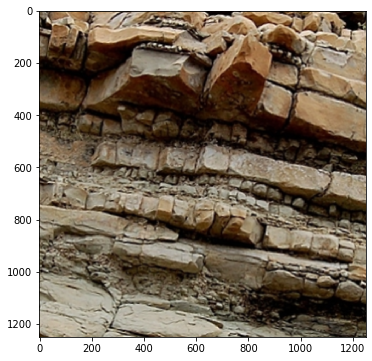

In [6]:
background=load_random_background()
plt.figure(figsize = (6,6))
plt.imshow(cv2.cvtColor(background,cv2.COLOR_BGR2RGB))

## Load a chessboard at a random 90 degree rotation and overlay the chessboard on a background function

In [7]:
# Overlay transparent image over background function
def image_over_background(image, background):
    
    # Overlay image over background in three steps
    # Create alpha mask
    mask_image=image[:,:,3]
    # Condition must be the same dimension as [x,y]
    mask_image=np.stack([mask_image]*3,-1) 
    # numpy.where(condition[, x, y]): Where True, yield x, otherwise yield y.
    final=np.where(mask_image,image[:,:,0:3],background) 
    
    return final

In [8]:
# Load a chessboard rotate it by either 0, 90, 180 or 270 degrees and resize it to (board_imageW, board_imageH) function
def load_chessboard(fd=fin_dim, bd=board_dim):
    
    # Load a chessboard
    chessboard=cv2.imread('CHESSBOARD.png', cv2.IMREAD_UNCHANGED) #CHANGE to your own chessboard
   
    # Resize it to the size of the board size 
    chessboard=cv2.resize(chessboard, (bd, bd))
    
    # Define the rotation transformation
    rotation_list=[0,90,180,270]
    
    transf_affine1 = iaa.Sequential([
        iaa.Affine(
            rotate=(random.choice(rotation_list))
        )
    ], random_order=False)
    
    chessboard=transf_affine1(image=chessboard)
    
    # Background blank image
    blank_image = np.zeros((fd,fd,4), np.uint8)

    # The chessboard must be positioned in the middle of the blank image (0,0,0,0)
    spawn_p=int((fd-bd)/2)

    blank_image[spawn_p:spawn_p+bd, spawn_p:spawn_p+bd]=chessboard

    final=image_over_background(blank_image,load_random_background())
    
    return final

### Test the function

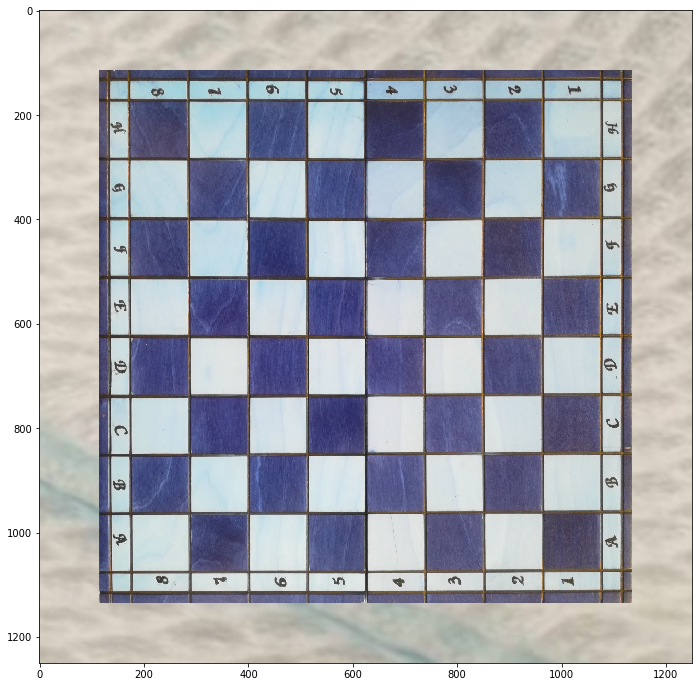

In [9]:
chessboard=load_chessboard()
plt.figure(figsize = (12,12))
plt.imshow(chessboard)

## Find bouding box on piece image function (+ plot bounding box function)

In [10]:
def find_boundingbox(img):
    # axis 0 is the row(y) and axis(x) 1 is the column
    y,x = img[:,:,3].nonzero() # get the nonzero alpha coordinates
    minx = np.min(x)
    miny = np.min(y)
    maxx = np.max(x)
    maxy = np.max(y)
    keypoints=[ia.Keypoint(x=minx,y=miny),ia.Keypoint(x=maxx,y=maxy),ia.Keypoint(x=minx,y=maxy),ia.Keypoint(x=maxx,y=miny)]
    return keypoints

def plot_boundingbox(keypoints):
    minx =keypoints[0].x
    miny=keypoints[0].y
    maxx=keypoints[1].x
    maxy=keypoints[1].y
    plt.plot([minx,minx,maxx,maxx,minx], [miny,maxy,maxy,miny,miny], color='red', linewidth=1)
    plt.scatter([minx,minx,maxx,maxx], [miny,maxy,miny,maxy], color='red')
    return

### Test the function

time elapsed =  0.012506723403930664 seconds


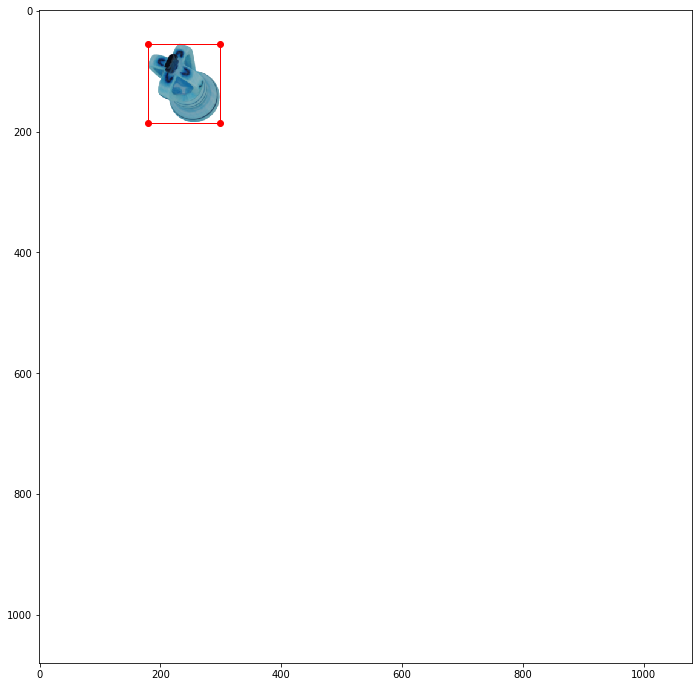

In [11]:
img=cv2.imread('TEST-IMG.png', cv2.IMREAD_UNCHANGED)
start = time.time()
bb=find_boundingbox(img)
end = time.time()
print('time elapsed = ',end - start, 'seconds')
plt.figure(figsize = (12,12))
plt.imshow(img)
plot_boundingbox(bb)

## Overlay piece on the chessboard fuction
More on how to generate a uniformly distributed random point within a circle: https://programming.guide/random-point-within-circle.html

In [12]:
# Generate a unitary disctibuted random point (x,y) in a cirlce with radius of r=pix [pixels] and center at (0,0)
def circle_unitary_distribution(pix):
    
    # Radius of the circle
    circle_r = pix
    
    # Center of the circle (x, y)
    circle_x = 0
    circle_y = 0

    # Random angle
    alpha = 2 * math.pi * random.random()
    
    # Random radius
    r = circle_r * math.sqrt(random.random())
    
    # Calculating the coordinates
    x = r * math.cos(alpha) + circle_x
    y = r * math.sin(alpha) + circle_y
    
    return int(x), int(y)


# Overlay transparent image over background function
def piece_on_chessboard(image,board, fd=fin_dim, od=orig_dim):
    
    # Background blank image
    blank_image = np.zeros((fd,fd,4), np.uint8)

    # The piece is not positioned in the middle of the blank image but is instead added a random displacement x,y
    # The displacement is a unitary distribution between points in a circle with radius=small amount of pixels
    spawn_p=int((fd-od)/2)
    
    displacement_pixels=8 # CHANGE
    x, y=circle_unitary_distribution(displacement_pixels)

    blank_image[spawn_p+x:spawn_p+od+x, spawn_p+y:spawn_p+od+y]=image
    
    # Find bounding box of the piece
    bb=find_boundingbox(blank_image)
    
    # Overlay image over background in three steps
    # Create alpha mask
    mask_image=blank_image[:,:,3]
    # Condition must be the same dimension as [x,y]
    mask_image=np.stack([mask_image]*3,-1) 
    # numpy.where(condition[, x, y]): Where True, yield x, otherwise yield y.
    final=np.where(mask_image,blank_image[:,:,0:3],board) 
    
    return final,bb

### Test the function

time elapsed =  0.5043630599975586 seconds


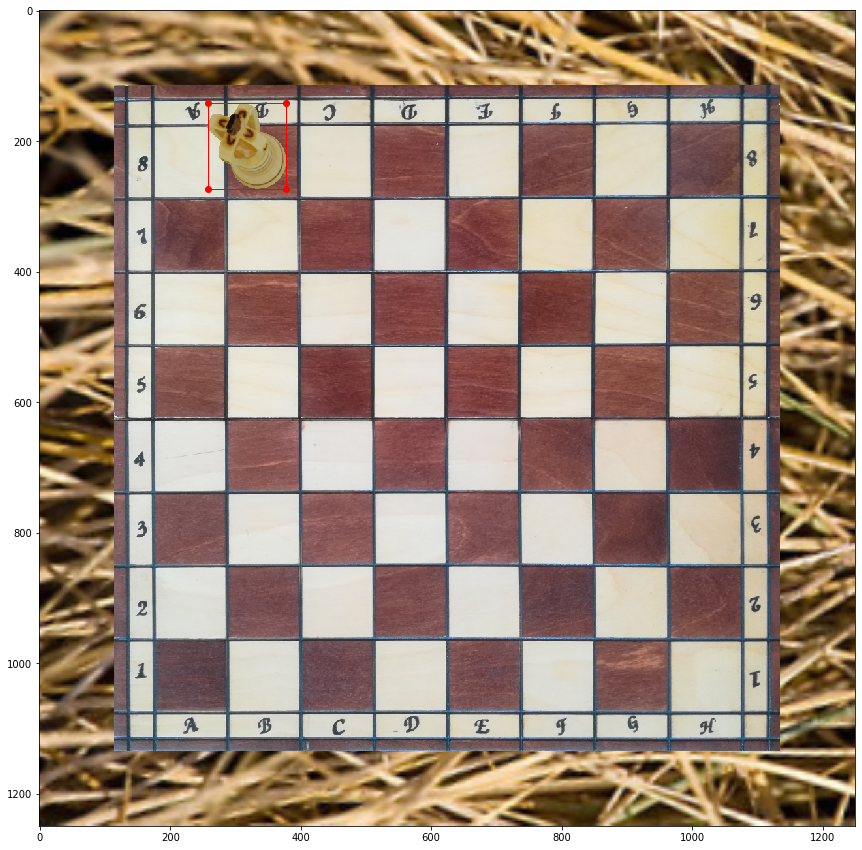

In [13]:
img=cv2.imread('TEST-IMG.png', cv2.IMREAD_UNCHANGED)
start = time.time()
final,bb=piece_on_chessboard(img, load_chessboard())
end = time.time()
print('time elapsed = ',end - start, 'seconds')
plt.figure(figsize = (15,15))
plt.imshow(cv2.cvtColor(final,cv2.COLOR_BGR2RGBA))
plot_boundingbox(bb)

# Composition generation function
The following table connects the name of each piece with the piece index and the piece class name. The latter follows from [FEN](https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation) notation.

| INDEX | PIECE NAME | CLASS NAME |
| :-: | :-: | :-: |
| 0 | bishop black | b |
| 1 | bishop white | B |
| 2 | king black | k |
| 3 | king white | K |
| 4 | knight black | n |
| 5 | knight white | N |
| 6 | pawn black | p |
| 7 | pawn white | P |
| 8 | queen black | q |
| 9 | queen white | Q |
| 10 | rook black | r |
| 11 | rook white | R |

## Create composition

In [14]:
# Generate list of lenght n of pieces numbers
def pieces_list(n):
    
    x=int((n-1)/12)+1
    
    number_list=[]  
    for i in range(x):
        options=[0,1,2,3,4,5,6,7,8,9,10,11] # indices of all different pieces
        random.shuffle(options)
        for j in range(12):
            number_list.append(options[j])

    number_list=number_list[:n]
    
    return number_list

# Pick n numbers from 64 in ascending order
def fields_list(n):
    
    numbers=random.sample(range(1, 65), n)
    numbers.sort()
    
    return numbers

In [15]:
def compose_chessboard(n):
    
    if n<1 or n>64:
        raise ValueError('Number of pieces n must be between 1 and 64.')
    
    # Load chessboard
    chessboard=load_chessboard()
    
    # Generate n random chessboard fields with their respective random pieces
    pieces=pieces_list(n)
    fields=fields_list(n)
    
    # Overlay pieces on the chessboard and remember their bounding boxes
    bb_list=[]
    for i in range(n):
        name=str(pieces[i])+'_'+str(fields[i])+'_'+str(random.randint(1,16))+'.png'
        name=os.path.join(pathpieces, name)
        piece_img=cv2.imread(name, cv2.IMREAD_UNCHANGED)
        chessboard, bb=piece_on_chessboard(piece_img, chessboard)
        bb_list.append(bb)
    
    return chessboard, pieces, bb_list

### Test the function 

time elapsed =  2.014979600906372 seconds


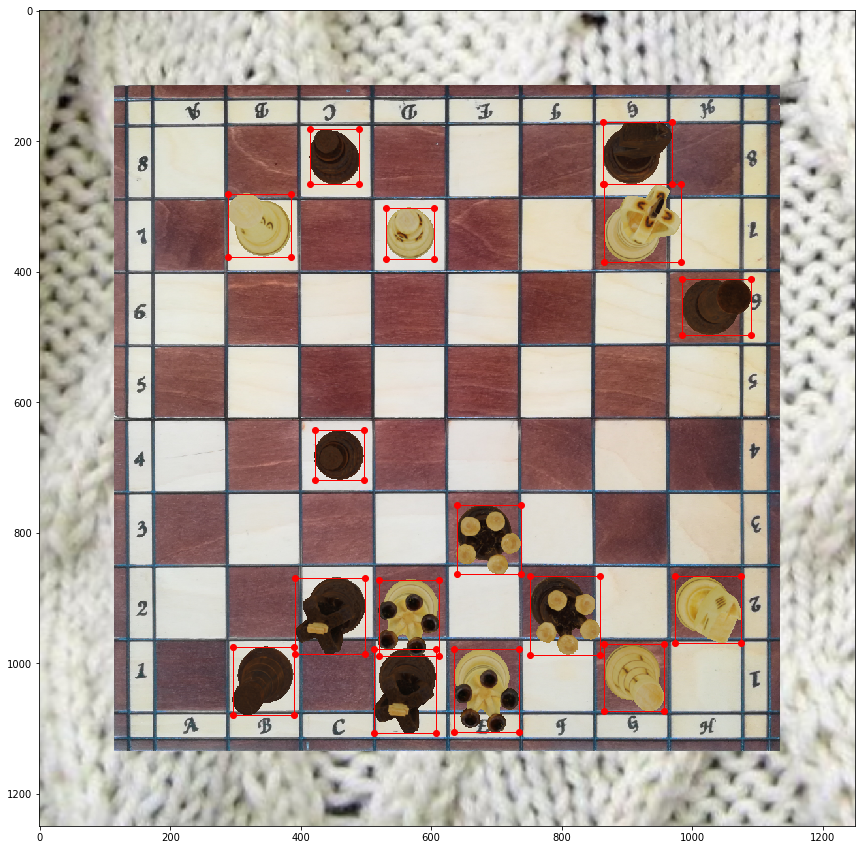

In [16]:
n=16

start = time.time()
final, pieces, bb=compose_chessboard(n)
end = time.time()
print('time elapsed = ',end - start, 'seconds')

plt.figure(figsize = (15,15))
plt.imshow(cv2.cvtColor(final,cv2.COLOR_BGR2RGBA))
for i in range(len(bb)):
    plot_boundingbox(bb[i])

## Transform composition

In [17]:
def transform_composition(composition, bb, ed=end_dim,od=orig_dim):
    
    dim=composition.shape[0]
    fact=ed/od
    
    # Rotate the image
    angle_of_rot=1.5 #CHANGE
    edge=65 #CHANGE
    
    transf_affine = iaa.Sequential([
        iaa.Affine(
            rotate=(-angle_of_rot,angle_of_rot)
        )
    ], random_order=False)
    
    bb2=[]
    for i in range(len(bb)):
        for j in range(4):
            bb2.append(bb[i][j])
    
    bb2=ia.KeypointsOnImage(bb2, shape=composition.shape)
    composition, bb2=transf_affine(image=composition, keypoints=bb2)   
       
    
    # Crop the biggest possible square in the rotated image
    b1=int(dim/(1+1/np.tan(angle_of_rot*np.pi/180)+1/np.sin(angle_of_rot*np.pi/180)))+edge
    b2=dim-b1
    composition=composition[b1:b2,b1:b2]
    
    # Repositions the keypoints according to the crop
    for i in range(len(bb2)):
        bb2[i].x=bb2[i].x-b1
        bb2[i].y=bb2[i].y-b1
        

        
    transf_affine2 = iaa.Sequential([
            iaa.Resize(ed)
    ], random_order=False)
    
    
    bb2= ia.KeypointsOnImage(bb2, shape=composition.shape)
    composition, bb2=transf_affine2(image=composition, keypoints=bb2) 

    
    keypoints=[]
    for i in range(int(len(bb2)/4)):
        keypoints.append([bb2[0+i*4],bb2[1+i*4],bb2[2+i*4],bb2[3+i*4]])
        
        
    # Contrast, brightness and hue transformations
    transf_brightness= iaa.Sequential([
        iaa.LinearContrast((0.85,1.15)),# CHANGE
        iaa.Multiply((0.85, 1.15)), # CHANGE
        iaa.MultiplyHue((0.95,1.05)) # CHANGE
    ])
    
    composition=transf_brightness(image=composition)
    
    return composition, keypoints

### Test the function

time elapsed =  1.8797869682312012 seconds


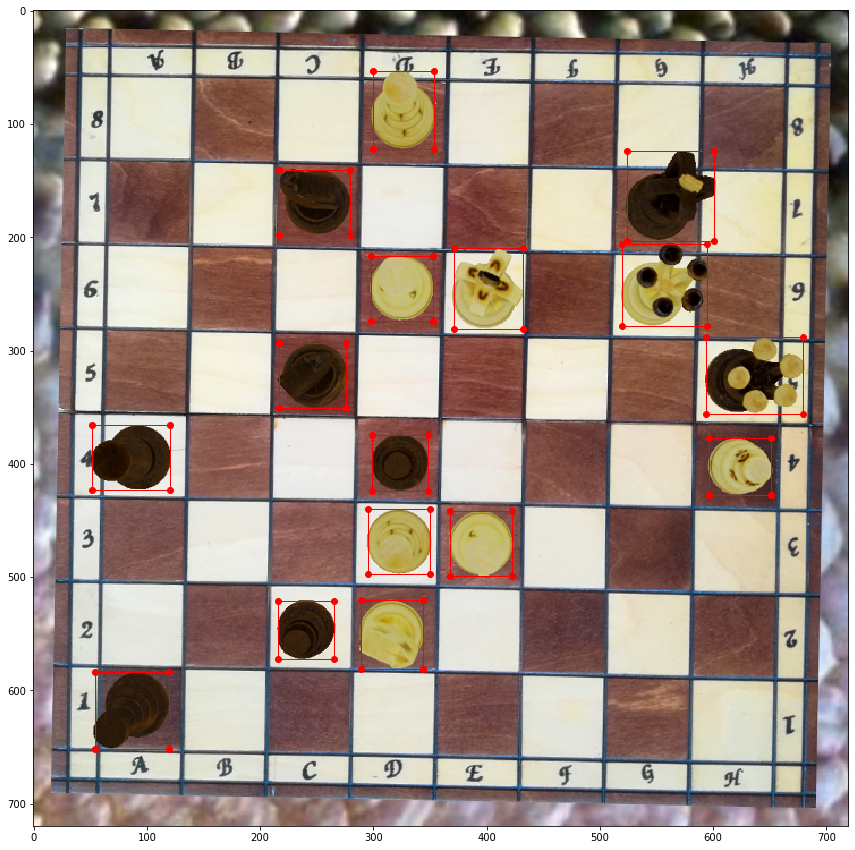

In [18]:
n=16

start = time.time()
final, pieces, bb=compose_chessboard(n)
final, bb=transform_composition(final, bb)
end = time.time()
print('time elapsed = ',end - start, 'seconds')

plt.figure(figsize = (15,15))
plt.imshow(cv2.cvtColor(final,cv2.COLOR_BGR2RGBA))
for i in range(len(bb)):
    plot_boundingbox(bb[i])

# Generate synthetic data for YOLO object detection algorithm

Create the output folder.

In [4]:
pathgenerate='obj' # Final destination of generated data

if not os.path.exists(pathgenerate):
    os.makedirs(pathgenerate)

Images should be labeled in the Darknet format. For the details see: https://github.com/ultralytics/yolov3/wiki/Train-Custom-Data. It is also important that the generated images are in the .jpg format.

In [19]:
# Transform the bounding box coordinates to Darknet format
def boudingbox_to_darknet_format(keypoints, dim):
    
    # Find the Boundingbox(xmin, ymin, xmax, ymax) pixels  
    xs=[kp.x for kp in keypoints]
    ys=[kp.y for kp in keypoints]
    
    xmin=min(xs)
    ymin=min(ys)
    xmax=max(xs)
    ymax=max(ys)
    
    x_center=(xmin+xmax)/2
    width=xmax-xmin
    y_center=(ymin+ymax)/2
    height=ymax-ymin
    
    # Coordinates must be normalized 
    x_center=x_center/dim
    width=width/dim
    y_center=y_center/dim
    height=height/dim
    
    return (x_center, y_center, width, height)

In [20]:
# Genereta data for the first scene function
def generate_scene(n, up):
    low=len(glob.glob1(pathgenerate,'scene'+str(n)+'_*.jpg'))
    if low>=up:
        return
    for i in tqdm(range(low, up), position=0, leave=True):
        final, pieces, bb=compose_chessboard(n)
        final, keypoints=transform_composition(final, bb)
        cv2.imwrite(os.path.join(pathgenerate,'scene'+str(n)+'_'+str(i)+'.jpg'), final) # save as .jpg to save some trouble later
        if os.path.exists(os.path.join(pathgenerate,'scene'+str(n)+'_'+str(i)+'.txt')):
            os.remove(os.path.join(pathgenerate,'scene'+str(n)+'_'+str(i)+'.txt')) # this deletes the file
        f= open(os.path.join(pathgenerate,'scene'+str(n)+'_'+str(i)+'.txt'),'a')
        
        # Convert Boundingboxes to darnet format
        dim=final.shape[0]
        for i in range(len(keypoints)):
            bbox=boudingbox_to_darknet_format(keypoints[i], dim)
            f.write(str(pieces[i])+' '+str(bbox[0])+' '+str(bbox[1])+' '+str(bbox[2])+' '+str(bbox[3])+'\n')
        f.close()
    return

In [21]:
assert False # Stops cell run

AssertionError: 

### Generate
Choose the number of pieces on the board ('n') and the respective number of generated compositions ('amount'). 

In [ ]:
# generate_scene(n, amount)

generate_scene(32, 5000)
generate_scene(24, 20000)
generate_scene(20, 25000)
generate_scene(16, 20000)
generate_scene(12, 20000)
generate_scene(8, 10000)